### Node based encoding

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.dataset import DatasetEphy
from frites.estimator import GCMIEstimator
from frites.stats import confidence_interval
from frites.utils import parallel_func
from frites.workflow import WfMi
from scipy.signal import fftconvolve
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.graphics import plot
from GDa.loader import loader
from GDa.session import session_info
from GDa.util import average_stages, shuffle_along_axis

##### Setting configurations

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [4]:
metric = "coh"
monkey = "lucy"
ds = 1

In [5]:
early_cue, early_delay = return_delay_split(monkey, delay_type=ds)

In [6]:
sessions = get_dates(monkey)

In [7]:
reg_colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [8]:
stages = [[-0.6, 0.2], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [9]:
bands = [[0, 6], [6, 14], [14, 26], [26, 42], [42, 80]]

In [10]:
path = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/power")

In [12]:
p_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "pval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)
t_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "tval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)

t_pow = t_pow * (p_pow <= 0.01)
"""
t_pow_avg = []
for ti, tf in stages:
    t_pow_avg += [t_pow.sel(times=slice(ti, tf)).mean("times")]
t_pow = xr.concat(t_pow_avg, "times")
""";

In [13]:
# Get the region name for each roi
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in t_pow.roi.data])
idx = np.argsort(regions)

In [14]:
def mi_visual_subsample(roi="V1", nboots=100, slvr_only=True):
    tt = 1
    br = 1
    at = "cue"
    avg = False

    sxx = []
    stim = []
    for s_id in tqdm(sessions):
        _FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"
        path_pow = os.path.join(_ROOT, f"Results/{monkey}/{s_id}/session01", _FILE_NAME)
        power = xr.load_dataarray(path_pow)
        rois = power.roi.data
        attrs = power.attrs
        sel_idx = rois == roi
        # Remove SLVR channels if slvr_only=False
        info = session_info(
            raw_path=os.path.join(_ROOT, "GrayLab"),
            monkey=monkey,
            date=s_id,
            session=1,
        )
        
        slvr_idx = info.recording_info["slvr"].astype(bool)
        if not bool(slvr_only):
            sel_idx = np.logical_and(np.logical_not(slvr_idx), sel_idx)
        else:
            sel_idx = np.logical_and(slvr_idx, sel_idx)

        power = power.isel(roi=sel_idx)

        # Averages power for each period (baseline, cue, delay, match) if needed
        # out = average_stages(power, avg, early_cue=early_cue,
        # early_delay=early_delay)
        # Average epochs
        out = []
        if avg:
            for t0, t1 in stages:
                out += [power.sel(times=slice(t0, t1)).mean("times")]
            out = xr.concat(out, "times")
            out = out.transpose("trials", "roi", "freqs", "times")
        else:
            out = power
        out.attrs = attrs
        sxx += [out.isel(roi=[r]) for r in range(len(out["roi"]))]
        stim += [out.attrs["stim"].astype(int)] * len(out["roi"])

    mis = []
    pvals = []
    tvals = []
    for boot in tqdm(range(nboots)):

        # Subsample indexes
        idx = np.random.choice(range(len(sxx)), size=20, replace=False)

        sxx_ = [sxx[i] for i in idx]
        stim_ = [stim[i] for i in idx]

        # Convert to DatasetEphy
        dt = DatasetEphy(sxx_, y=stim_, nb_min_suj=10, times="times", roi="roi")

        mi_type = "cd"
        inference = "rfx"
        kernel = None

        if avg:
            mcp = "fdr"
        else:
            mcp = "cluster"

        mi_type = "cd"

        estimator = GCMIEstimator(
            mi_type="cd",
            copnorm=True,
            biascorrect=True,
            demeaned=False,
            tensor=True,
            gpu=False,
            verbose=False,
        )
        wf = WfMi(mi_type, inference, verbose=False, kernel=kernel, estimator=estimator)

        kw = dict(n_jobs=30, n_perm=200)
        cluster_th = None

        mi, pvalues = wf.fit(dt, mcp=mcp, cluster_th=cluster_th, **kw)
        mis += [mi]
        pvals += [pvalues]
        
        t_pow = wf.tvalues * (pvalues <= 0.01)

        t_pow_avg = []
        for ti, tf in stages:
            t_pow_avg += [t_pow.sel(times=slice(ti, tf)).mean("times")]
        t_pow = xr.concat(t_pow_avg, "times")  
        
        tvals += [t_pow]
        
    df = xr.concat(tvals, "boot").squeeze()
    return df  # confidence_interval((df < alpha).astype(int), axis=0).squeeze()

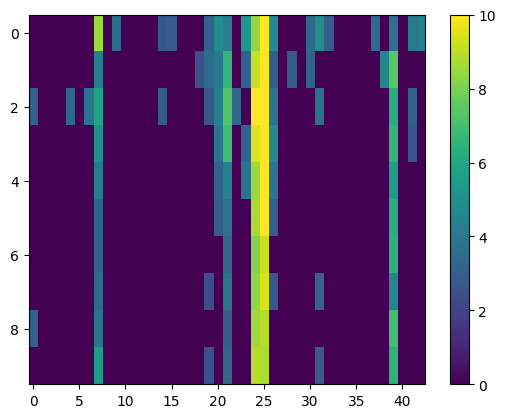

In [22]:
plt.imshow(t_pow.sel(times=1), aspect="auto", vmax=10)
plt.colorbar()

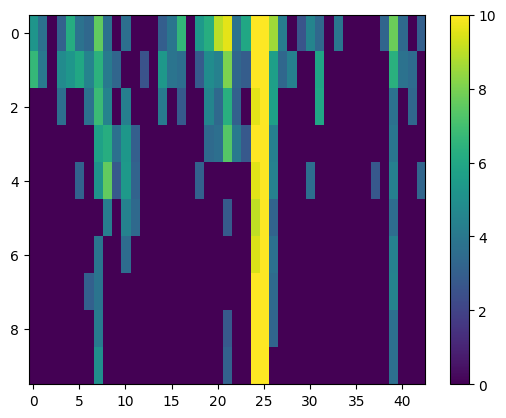

In [23]:
plt.imshow(t_pow.sel(times=2), aspect="auto", vmax=10)
plt.colorbar()

In [14]:
ci_v1 = mi_visual_subsample(roi="V1", nboots=100, slvr_only=False)

  2%|█▍                                                                                        | 1/62 [00:06<07:00,  6.89s/it]

KeyboardInterrupt



In [ ]:
ci_v1_noslvr = mi_visual_subsample(roi="V1", nboots=100, slvr_only=True)

In [ ]:
ci_v2 = mi_visual_subsample(roi="V2", nboots=100, slvr_only=False)

In [ ]:
ci_v2_noslvr = mi_visual_subsample(roi="V2", nboots=100, slvr_only=True)

In [14]:
data_loader = loader(_ROOT=_ROOT)

kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

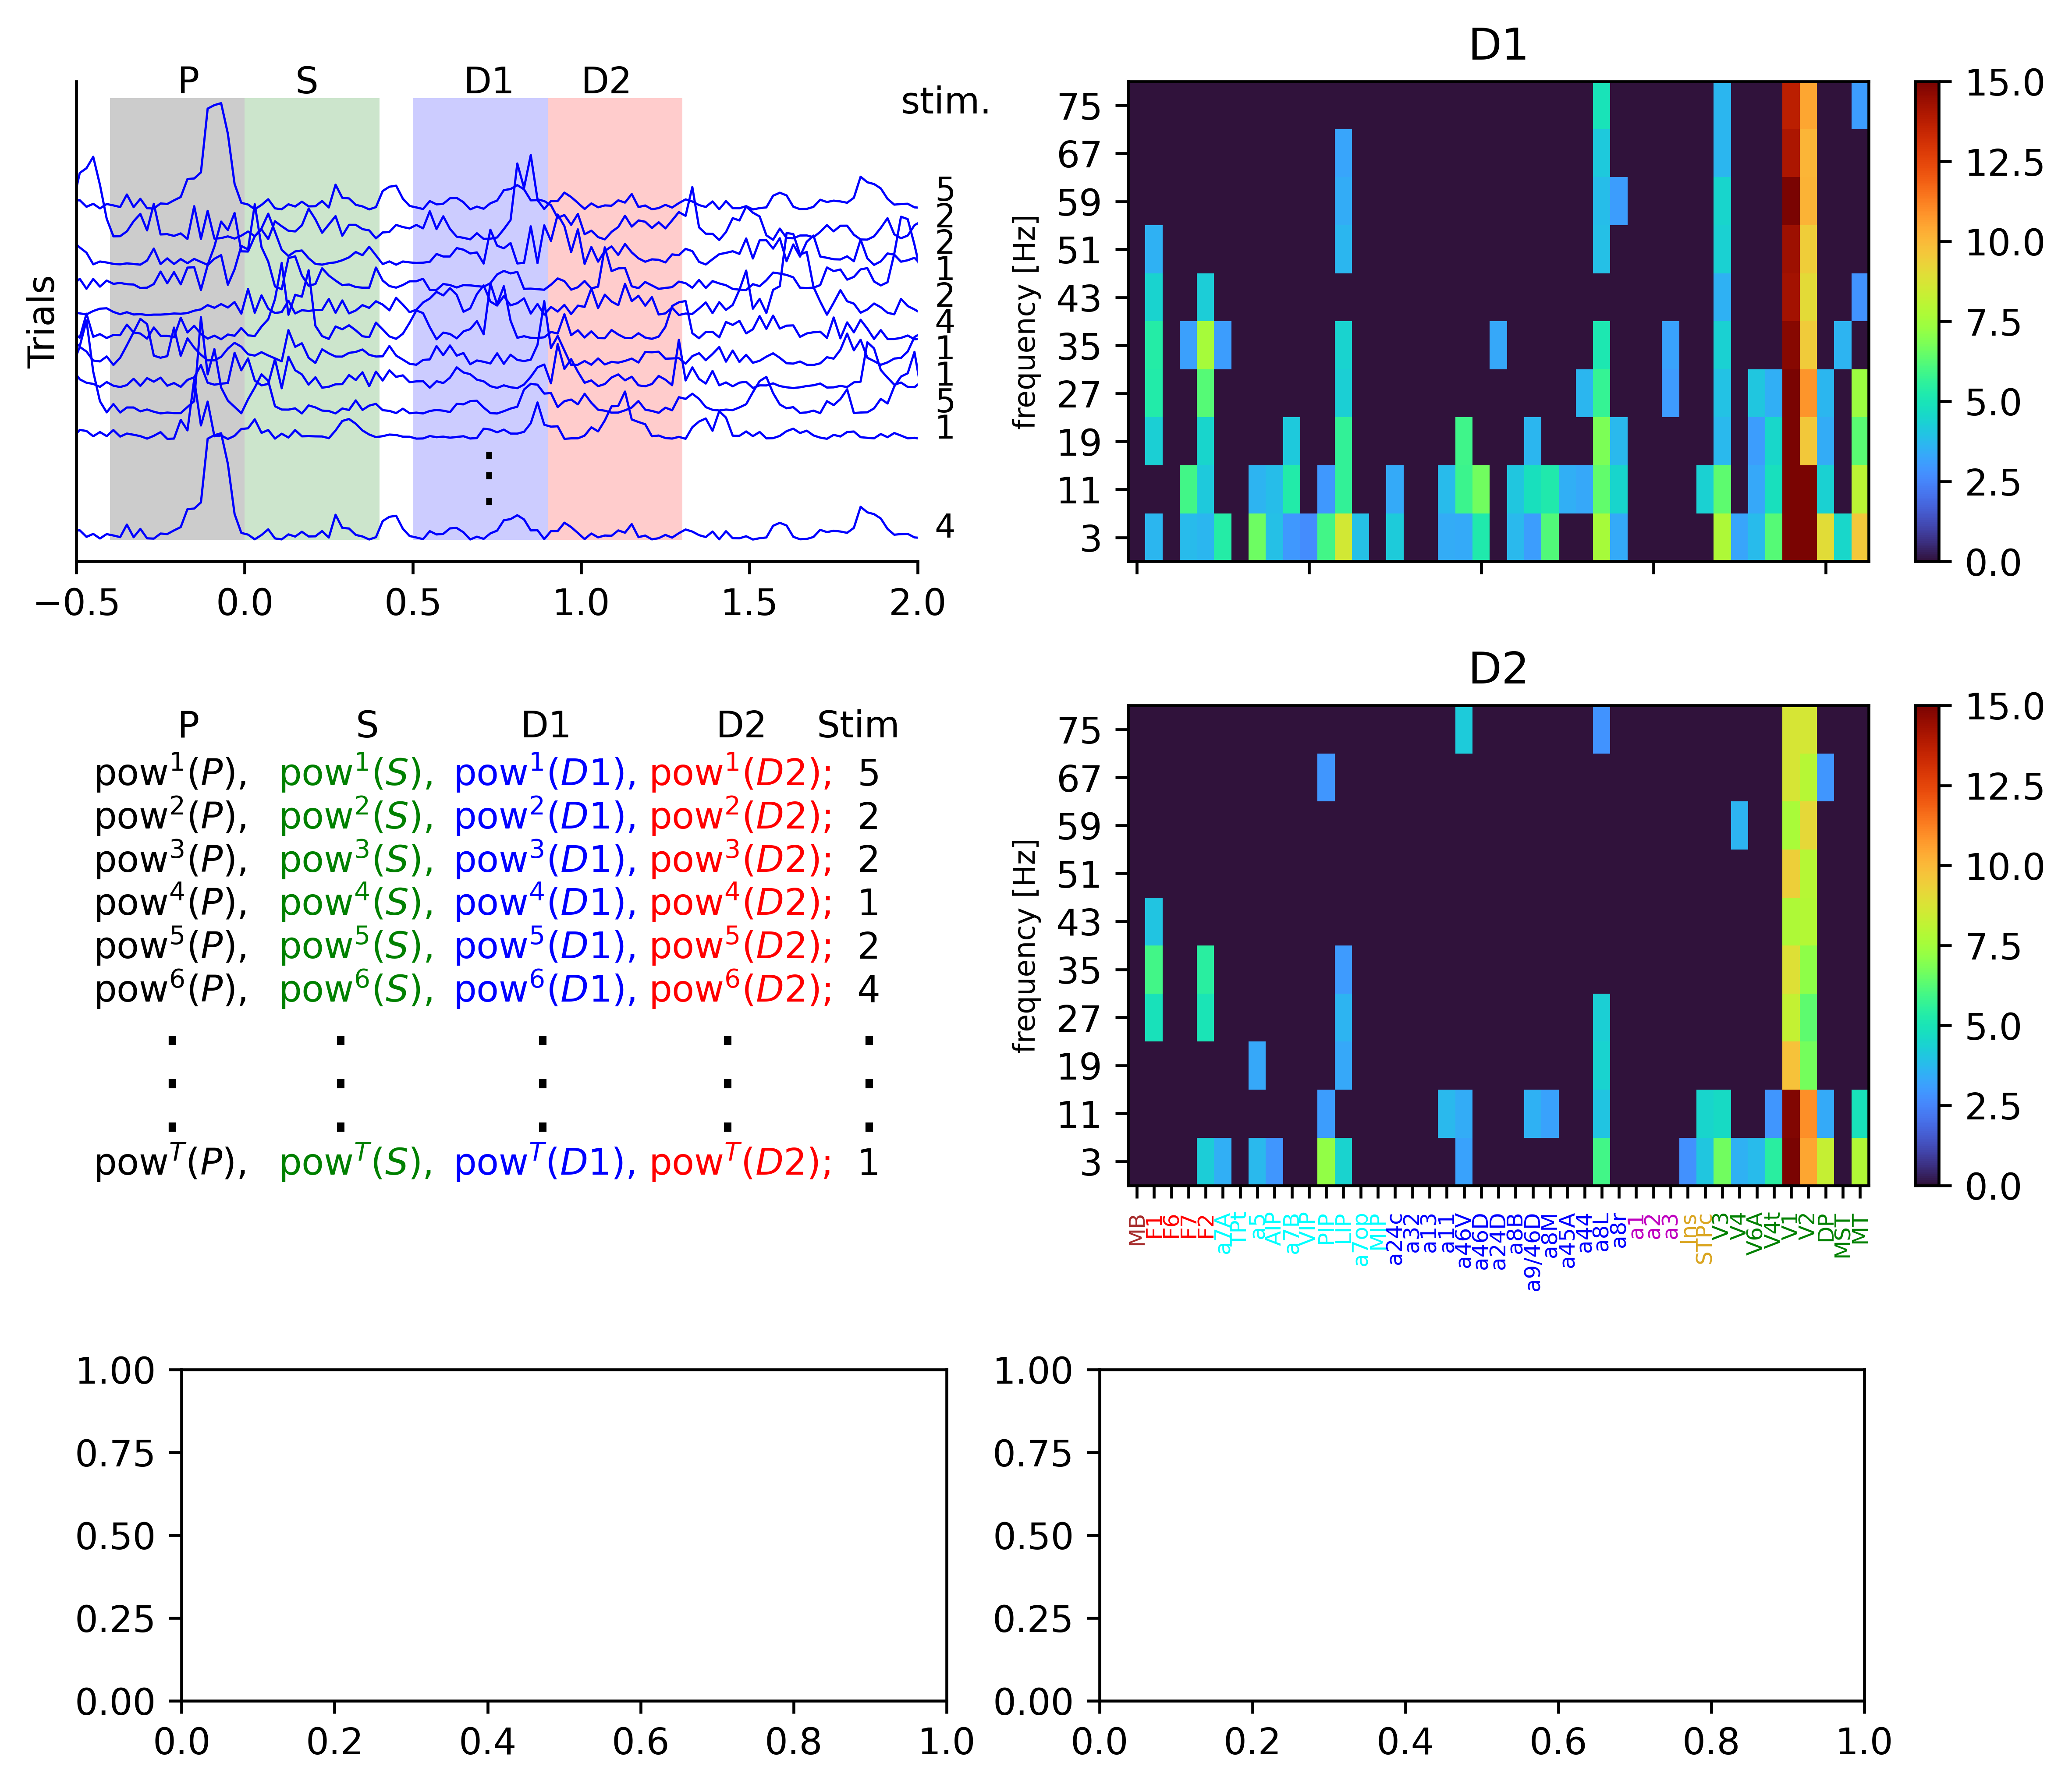

In [23]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(8, 7), dpi=600)

gs0 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.05,
    right=0.45,
    hspace=0.3,
    bottom=0.35,
    top=0.95,
    height_ratios=(1, 1),
)

gs1 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.55,
    right=0.99,
    hspace=0.3,
    bottom=0.35,
    top=0.95,
    height_ratios=(1, 1),
)

gs2 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.1,
    right=0.90,
    hspace=0.3,
    bottom=0.07,
    top=0.25,
)

axs0 = [plt.subplot(gs0[i]) for i in range(2)]

plt.sca(axs0[0])
v1ts = power_task.isel(roi=85).sel(freqs=27)
v1ts = (v1ts - v1ts.mean("times")) / v1ts.std("times")
times = v1ts.times.data

stims = np.random.randint(1, 6, 11)

for i in range(10):
    plt.plot(times, 3 * v1ts.isel(trials=i) + 5 * i, color="b", lw=0.6)
    plt.text(2.05, 5.2 * i - 2, f"{stims[i]}", fontsize=9)

plt.plot(times, 3 * v1ts.isel(trials=i) - 20, color="b", lw=0.6)
plt.text(2.05, -21.5, f"{stims[-1]}", fontsize=9)
plt.text(0.7, -15, ".", fontsize=15)
plt.text(0.7, -10, ".", fontsize=15)
plt.text(0.7, -6, ".", fontsize=15)
plt.text(1.95, 62, "stim.")
plt.xlim(-0.5, 2)

rP = Rectangle(
    (-0.4, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="k", alpha=0.2
)
rS = Rectangle(
    (0, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="g", alpha=0.2
)
rD1 = Rectangle(
    (0.5, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="b", alpha=0.2
)
rD2 = Rectangle(
    (0.9, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="r", alpha=0.2
)


axs0[0].add_patch(rP)
plt.text(-0.2, 66, "P")
axs0[0].add_patch(rS)
plt.text(0.15, 66, "S")
axs0[0].add_patch(rD1)
plt.text(0.65, 66, "D1")
axs0[0].add_patch(rD2)
plt.text(1.0, 66, "D2")


[axs0[0].spines[key].set_visible(False) for key in ["top", "right"]]
plt.yticks([])
plt.ylabel("Trials")

plt.sca(axs0[1])
plt.ylim(0, 90)
plt.xlim(-0.5, 2)


plt.text(-0.2, 84, "P")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(-0.25, xpos, ".", fontsize=20)
        continue
    plt.text(-0.45, xpos, f"pow$^{exp}(P)$,")

plt.text(0.33, 84, "S")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(0.25, xpos, ".", fontsize=20)
        continue
    plt.text(0.1, xpos, f"pow$^{exp}(S)$,", color="g")


plt.text(0.82, 84, "D1")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(0.85, xpos, ".", fontsize=20)
        continue
    plt.text(0.62, xpos, f"pow$^{exp}(D1)$,", color="b")

plt.text(1.4, 84, "D2")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(1.4, xpos, ".", fontsize=20)
        continue
    plt.text(1.2, xpos, f"pow$^{exp}(D2)$;", color="r")

plt.text(1.7, 84, "Stim")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(1.82, xpos, ".", fontsize=20)
        continue
    plt.text(1.82, xpos, f"{stims[i]}")
plt.axis("off")

axs1 = [plt.subplot(gs1[i]) for i in range(2)]

for i in range(2):
    plt.sca(axs1[i])
    plt.imshow(
        t_pow.sel(times=i + 2).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=15,
        cmap="turbo",
        origin="lower",
    )
    if i == 1:
        tks = plt.xticks(
            range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
        )
        [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
    plt.ylabel("frequency [Hz]", fontsize=8)
    cbar = plt.colorbar()
    plt.title(f"{stage_labels[i + 2]}")
plt.setp(axs1[0].get_xticklabels(), visible=False)


axs2 = [plt.subplot(gs2[i]) for i in range(2)]

ci = [ci_v1, ci_v2]
for pos in range(2):
    plt.sca(axs2[pos])
    for i in range(5):
        ci[pos].median("bound").isel(times=i).plot()
        plt.fill_between(
            ci[pos].freqs,
            ci[pos].sel(bound="low").isel(times=i),
            ci[pos].sel(bound="high").isel(times=i),
            alpha=0.4,
            label=f"{stage_labels[i]}",
        )
    if pos == 0:
        plt.title("V1", fontsize=10, pad=-1)
    else:
        plt.title("V2", fontsize=10, pad=-1)
        axs2[pos].legend(
            loc="right", bbox_to_anchor=(1.25, 0.45), ncol=1, fontsize=8, frameon=False
        )
        plt.ylabel("")
    plt.xlim(3, 75)
    plt.xticks(ci[pos].freqs.data.astype(int))
    plt.xlabel("frequency [Hz]")
    plt.ylabel("Fraction of significant \n encoding")
    [axs2[pos].spines[key].set_visible(False) for key in ["top", "right"]]
plt.xticks()
plt.setp(axs2[1].get_yticklabels(), visible=False)


plot.add_panel_letters(
    fig,
    axes=[axs0[0], axs1[0], axs1[1], axs2[0], axs2[1]],
    fontsize=12,
    xpos=[-0.1, -0.1, -0.1, -0.1, -0.1],
    ypos=[1.1, 1.1, 1.1, 1.1, 1.1],
)

bg = plot.Background(visible=False)

plt.savefig("figures/n3/figure7.pdf")

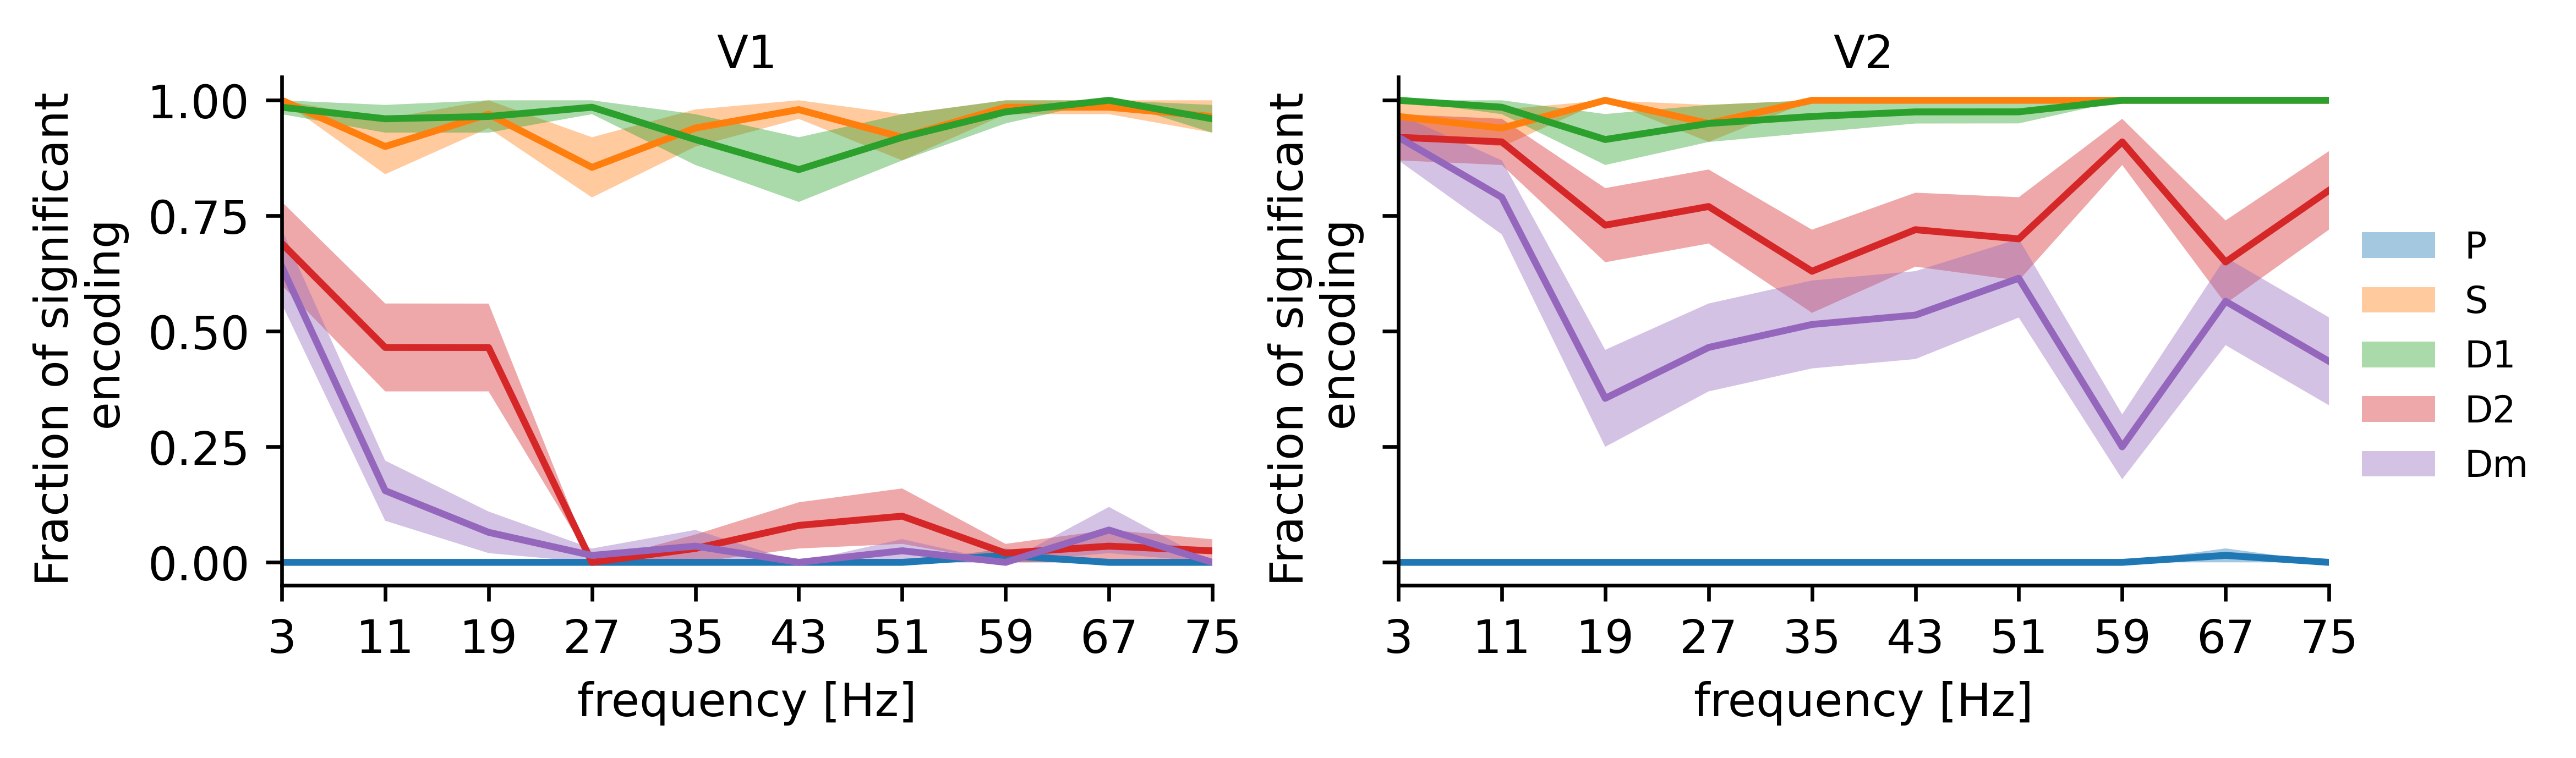

In [26]:
plt.figure(figsize=(8, 2), dpi=600)
ci = [ci_v1_noslvr, ci_v2_noslvr]
for pos in range(2):
    ax = plt.subplot(1, 2, pos + 1)
    for i in range(5):
        ci[pos].median("bound").isel(times=i).plot()
        plt.fill_between(
            ci[pos].freqs,
            ci[pos].sel(bound="low").isel(times=i),
            ci[pos].sel(bound="high").isel(times=i),
            alpha=0.4,
            label=f"{stage_labels[i]}",
        )
    if pos == 0:
        plt.title("V1", fontsize=10, pad=-1)
    else:
        plt.title("V2", fontsize=10, pad=-1)
        ax.legend(
            loc="right", bbox_to_anchor=(1.25, 0.45), ncol=1, fontsize=8, frameon=False
        )
        plt.ylabel("")
    plt.xlim(3, 75)
    plt.xticks(ci[pos].freqs.data.astype(int))
    plt.xlabel("frequency [Hz]")
    plt.ylabel("Fraction of significant \n encoding")
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xticks()
plt.setp(ax.get_yticklabels(), visible=False)

plt.savefig("figures/n3/figure7_slvr.png")

In [28]:
overlap = 1 * (p_pow <= 0.001) + 2 * (p_cc <= 0.001)

/tmp/ipykernel_3428667/3060752310.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("turbo")
/tmp/ipykernel_3428667/3060752310.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("hot_r")


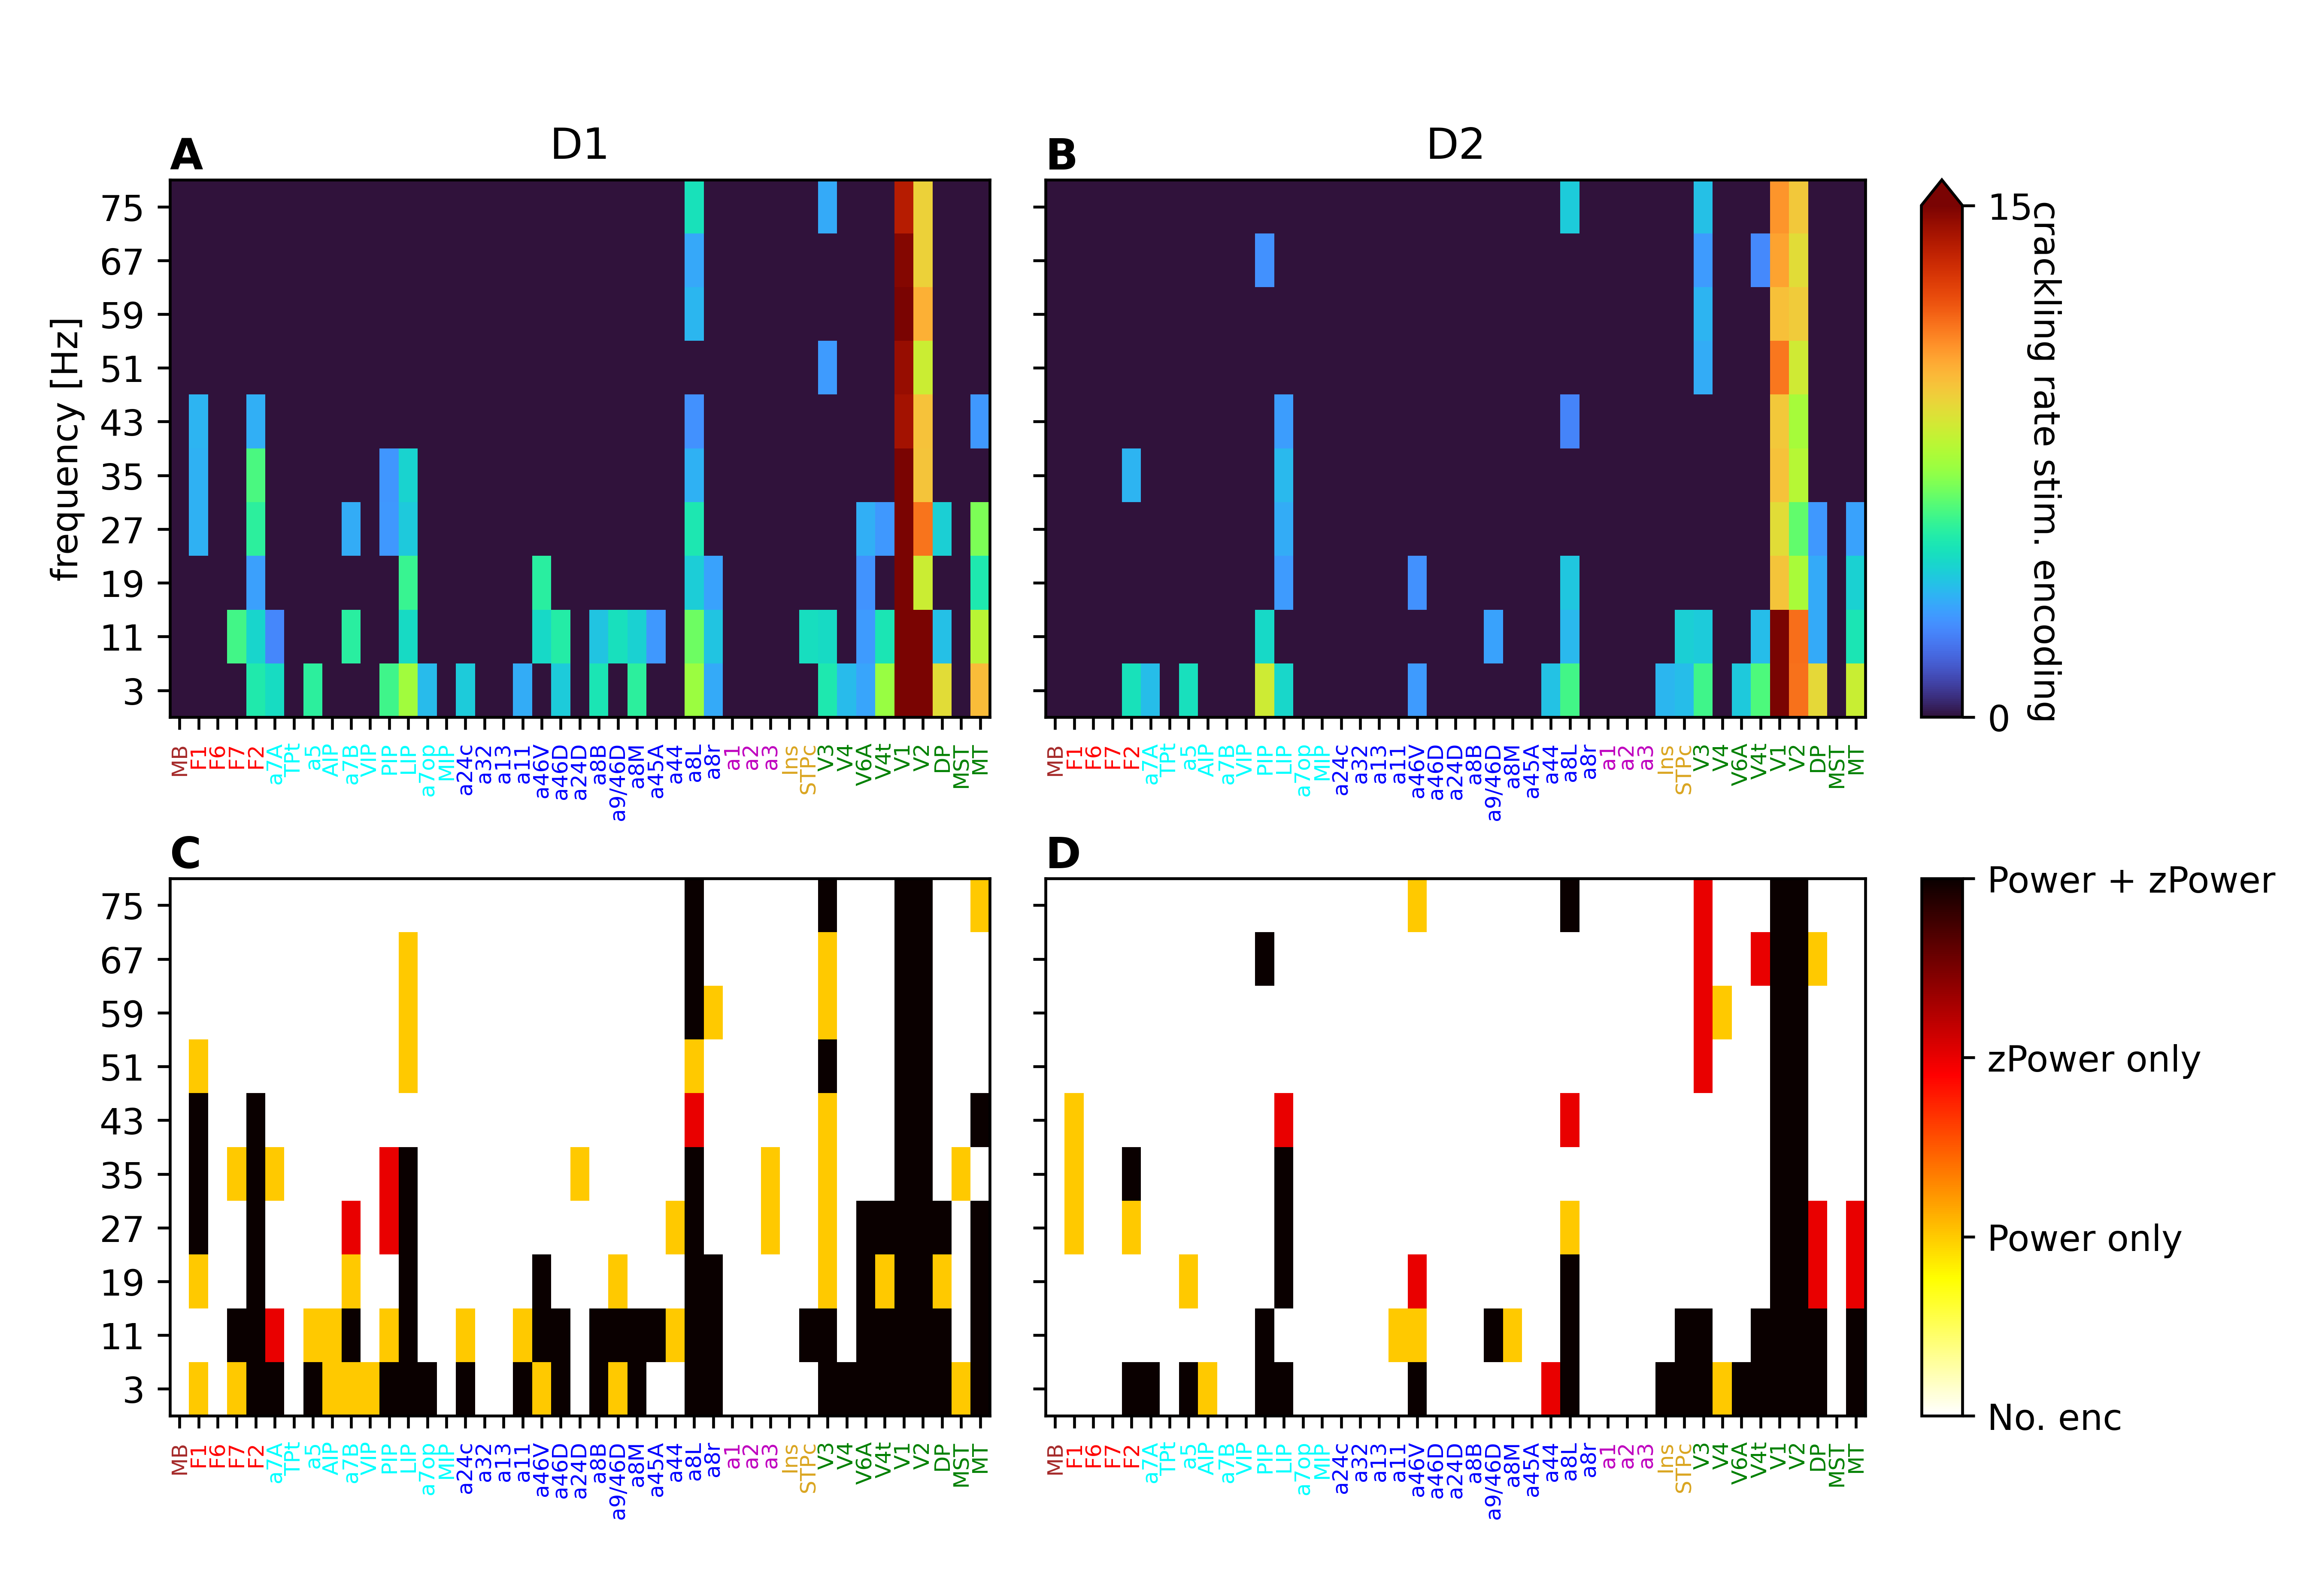

In [29]:
import matplotlib

fig = plt.figure(figsize=(8, 6), dpi=600)

gs0 = fig.add_gridspec(
    nrows=2,
    ncols=3,
    left=0.07,
    right=0.94,
    bottom=0.1,
    top=0.90,
    wspace=0.1,
    hspace=0.3,
    width_ratios=(1, 1, 0.05),
)

axs0 = [plt.subplot(gs0[i]) for i in range(6)]

for i in range(2):
    plt.sca(axs0[i])
    plt.imshow(
        t_crk.sel(times=i + 2).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=15,
        cmap="turbo",
        origin="lower",
    )
    if i == 0:
        plt.ylabel("frequency [Hz]", fontsize=10)
    tks = plt.xticks(
        range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
    )
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
    plt.title(f"{stage_labels[i + 2]}")
plt.setp(axs0[1].get_yticklabels(), visible=False)

norm = matplotlib.colors.Normalize(vmin=0, vmax=15)
cmap = matplotlib.cm.get_cmap("turbo")


cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 15],
    cax=axs0[2],
    extend="max",
)

cbar.ax.set_ylabel("crackling rate stim. encoding", rotation=270, labelpad=8)

##################################################################################################

for i in range(3, 5):
    plt.sca(axs0[i])
    plt.imshow(
        overlap.sel(times=i - 1).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=3,
        cmap="hot_r",
        origin="lower",
    )
    if i == 0:
        plt.ylabel("frequency [Hz]", fontsize=10)
    tks = plt.xticks(
        range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
    )
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
plt.setp(axs0[4].get_yticklabels(), visible=False)

norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
cmap = matplotlib.cm.get_cmap("hot_r")


cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 1, 2, 3],
    cax=axs0[5],
    extend=None,
)

cbar.ax.set_yticklabels(["No. enc", "Power only", "zPower only", "Power + zPower"])

cbar.ax.set_ylabel("", rotation=270, labelpad=9)

bg = plot.Background(visible=False)

plot.add_panel_letters(
    fig,
    axes=[axs0[0], axs0[1], axs0[3], axs0[4]],
    fontsize=12,
    xpos=[0, 0, 0, 0],
    ypos=[1.02, 1.02, 1.02, 1.02],
)


plt.savefig("figures/n3/figure8.pdf")

In [30]:
total = np.logical_or((p_pow <= 0.001), (p_cc <= 0.001)).sum("roi")

In [31]:
unP = (overlap == 1).sum("roi") / total
unC = (overlap == 2).sum("roi") / total
red = (overlap == 3).sum("roi") / total

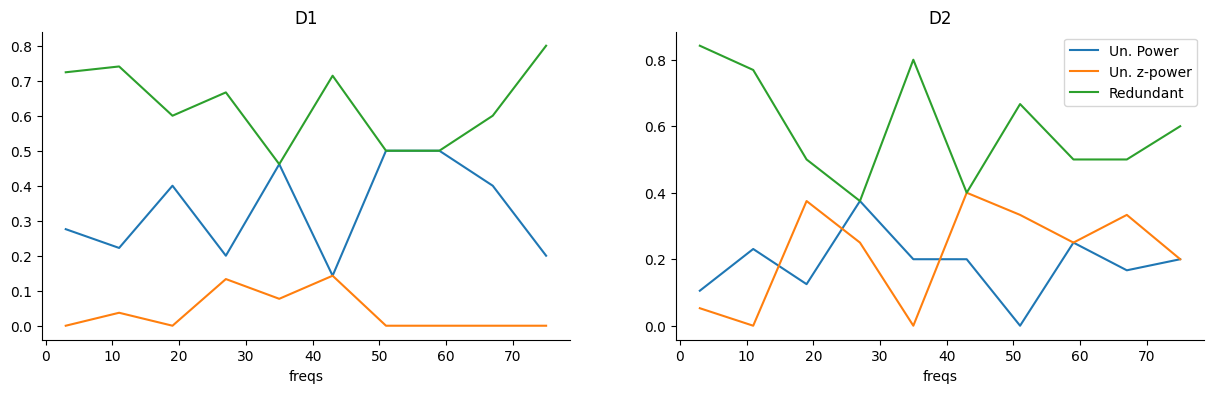

In [32]:
plt.figure(figsize=(15, 4))
for t in [2, 3]:
    ax = plt.subplot(1, 2, t - 1)
    unP.sel(times=t).plot(x="freqs")
    unC.sel(times=t).plot(x="freqs")
    red.sel(times=t).plot(x="freqs")

    if t == 3:
        plt.legend(["Un. Power", "Un. z-power", "Redundant"])
    plt.title(stage_labels[t])
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.ylabel("")

#### Figure paper

In [23]:
boot_v1 = []
boot_v2 = []

for t in range(5):

    boot_v1 += [
        np.random.choice((ci_v1 <= 0.01).sel(freqs=27, times=t), size=(100, 100)).mean(
            axis=0
        )
    ]
    boot_v2 += [
        np.random.choice((ci_v2 <= 0.01).sel(freqs=27, times=t), size=(100, 100)).mean(
            axis=0
        )
    ]

boot_v1 = np.stack(boot_v1, axis=0)
boot_v2 = np.stack(boot_v2, axis=0)

NameError: name 'ci_v2' is not defined

In [77]:
boot_v1_slvr = []
boot_v2_slvr = []

for t in range(5):

    boot_v1_slvr += [
        np.random.choice(
            (ci_v1_noslvr <= 0.01).sel(freqs=27, times=t), size=(100, 100)
        ).mean(axis=0)
    ]
    boot_v2_slvr += [
        np.random.choice(
            (ci_v2_noslvr <= 0.01).sel(freqs=27, times=t), size=(100, 100)
        ).mean(axis=0)
    ]

boot_v1_slvr = np.stack(boot_v1_slvr, axis=0)
boot_v2_slvr = np.stack(boot_v2_slvr, axis=0)

NameError: name 'boot_v1' is not defined

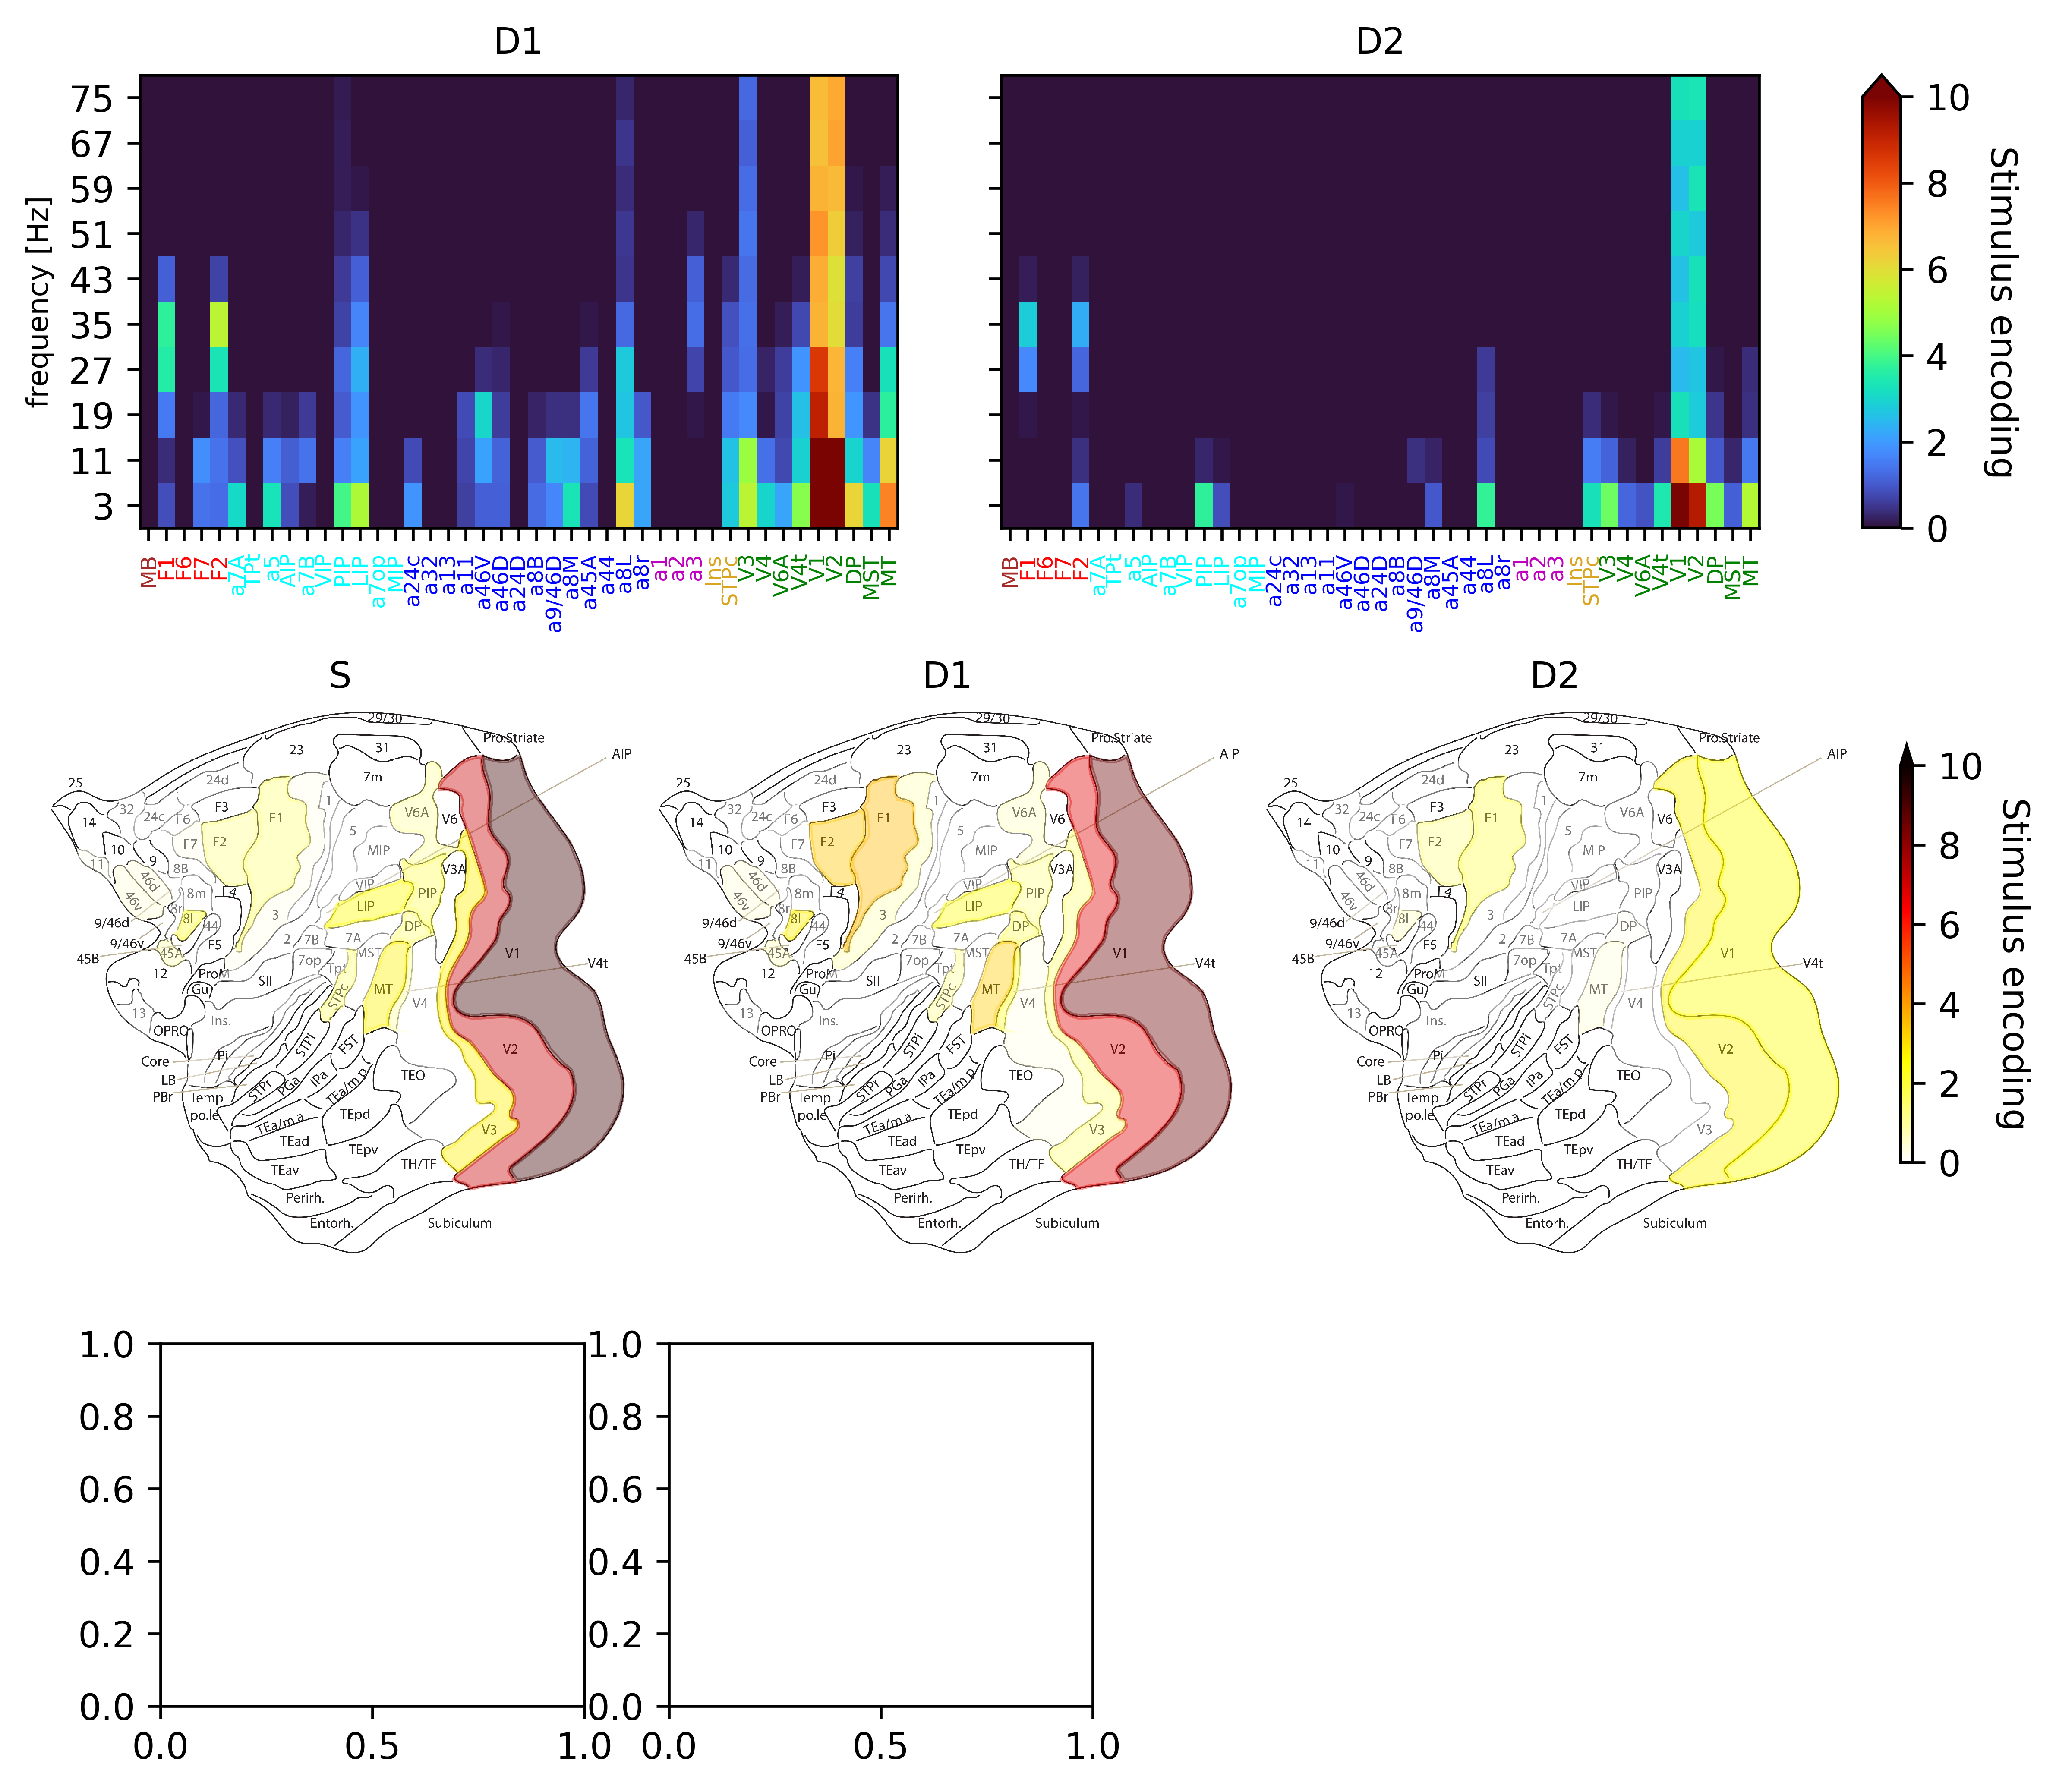

In [22]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(8, 7), dpi=600)


gs0 = fig.add_gridspec(
    nrows=1,
    ncols=3,
    left=0.07,
    right=0.92,
    hspace=0.1,
    bottom=0.7,
    top=0.95,
    width_ratios=(1, 1, 0.05),
)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=3,
    left=0.02,
    right=0.90,
    bottom=0.3,
    wspace=0,
    hspace=0.55,
    top=0.6,
)


gs1cb = fig.add_gridspec(
    nrows=1,
    ncols=3,
    left=0.92,
    right=0.94,
    bottom=0.35,
    top=0.58,
)

gs2 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.08,
    right=0.53,
    bottom=0.05,
    top=0.25,
)

axs0 = [plt.subplot(gs0[i]) for i in range(3)]
axs1 = [plt.subplot(gs1[i]) for i in range(3)]
axs1cb = plt.subplot(gs1cb[0])
axs2 = [plt.subplot(gs2[i]) for i in range(2)]

############################ ENCODING MAPS ############################

for i in range(2):
    plt.sca(axs0[i])
    plt.imshow(
        t_pow.sel(times=i + 2).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=10,
        cmap="turbo",
        origin="lower",
    )
    plt.title(f"D{i + 1}", fontsize=10)
    tks = plt.xticks(
        range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
    )
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
    if i == 0:
        plt.ylabel("frequency [Hz]", fontsize=8)
plt.setp(axs0[1].get_yticklabels(), visible=False)


norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
cmap = matplotlib.colormaps["turbo"]  # matplotlib.cm.get_cmap("jet")


cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    # ticks=[],
    cax=axs0[2],
    extend="max",
)
cbar.ax.set_ylabel(
    "Stimulus encoding",
    fontsize=10,
    rotation=270,
    labelpad=13,
)

############################ ENCODING MAPS ############################
def plot_brain_areas(ax, values):

    import matplotlib as mpl
    import matplotlib.patches as mpatches

    areas_dict = get_areas()

    area_no = dict(
        motor=0,
        parietal=1,
        prefrontal=2,
        somatosensory=3,
        temporal=4,
        visual=5,
        auditory=6,
    )

    areas = values.roi.data  # np.asarray([area for area in areas_dict.keys()])
    areas = [a.lower() for a in areas]
    fmap = flatmap(values.data, areas)

    fmap.plot(
        ax,
        ax_colorbar=None,
        cbar_title=None,
        alpha=0.4,
        colormap="hot_r",
        colors=None,
        vmin=0,
        vmax=10,
    )


plot_brain_areas(axs1[0], t_pow.sel(freqs=27, times=1))
plt.title(f"S", fontsize=10)
plot_brain_areas(axs1[1], t_pow.sel(freqs=27, times=2))
plt.title(f"D1", fontsize=10)
plot_brain_areas(axs1[2], t_pow.sel(freqs=27, times=3))
plt.title(f"D2", fontsize=10)

norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
cmap = matplotlib.colormaps["hot_r"]  # matplotlib.cm.get_cmap("jet")


cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    # ticks=[],
    cax=axs1cb,
    extend="max",
)
cbar.ax.set_ylabel(
    "Stimulus encoding",
    fontsize=10,
    rotation=270,
    labelpad=13,
)

############################ BOXPLOTS ############################
plt.sca(axs2[0])
sns.boxplot(data=boot_v1.T, showfliers=False, color="lightgreen")
sns.boxplot(data=boot_v2.T, showfliers=False, color="lightblue")
[axs2[0].spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("Stimulus encoding", fontsize=8)
plt.title("No SLVR channels", fontsize=8)
plt.ylim(-0.1, 1.1)
plt.xticks(range(5), stage_labels)


plt.sca(axs2[1])
sns.boxplot(data=boot_v1_slvr.T, showfliers=False, color="lightgreen")
sns.boxplot(data=boot_v2_slvr.T, showfliers=False, color="lightblue")
plt.legend(["V1", "V2"], frameon=False)
[axs2[1].spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylim(-0.1, 1.1)
plt.setp(axs2[1].get_yticklabels(), visible=False)
plt.xticks(range(5), stage_labels)
plt.title("Only SLVR channels", fontsize=8)

bg = plot.Background(visible=True)

#### Co-crackling and encoding

In [15]:
root = os.path.expanduser("~/funcog/gda/Results/lucy/pec")
Pb = []
for session in tqdm(sessions):
    temp = xr.load_dataarray(os.path.join(root, f"pec_st_{session}_at_cue.nc"))
    Pb += [
        [temp.sel(times=slice(ti, tf)).mean(("trials", "times")) for ti, tf in stages]
    ]
    Pb[-1] = xr.concat(Pb[-1], "times")
Pb = xr.concat(Pb, "roi").groupby("roi").mean("roi")

100%|█████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.44it/s]


In [16]:
root = os.path.expanduser("~/funcog/gda/Results/lucy/pec")
kij = []
for session in tqdm(sessions):
    temp = data_loader.load_co_crakcle(session, trial_type=1, strength=True, thr=0)
    kij += [temp]
kij_task = xr.concat(kij, "roi").groupby("roi").mean("roi")

100%|████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 116.91it/s]


In [17]:
root = os.path.expanduser("~/funcog/gda/Results/lucy/pec")
kij = []
for session in tqdm(sessions):
    temp = data_loader.load_co_crakcle(
        session, trial_type=1, strength=True, surrogate=True, thr=0
    )
    kij += [temp]
kij_fix = xr.concat(kij, "roi").groupby("roi").mean("roi")

100%|█████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.52it/s]


In [18]:
core = []
for session in tqdm(sessions):
    core += [xr.load_dataarray(
        os.path.join(
            os.path.expanduser("~/funcog/gda/Results/lucy"),
            session,
            "session01",
            "network",
            "pec_coreness_at_cue.nc",
        )
    )]
    
    core_avg = []
    for ti, tf in stages:
        core_avg += [core[-1].sel(times=slice(ti, tf)).mean(("times", "trials"))]
    core[-1] = xr.concat(core_avg, "times")

degree = []
for session in tqdm(sessions):
    degree += [xr.load_dataarray(
        os.path.join(
            os.path.expanduser("~/funcog/gda/Results/lucy"),
            session,
            "session01",
            "network",
            "pec_degree_at_cue.nc",
        )
    )]
    
    
    degree_avg = []
    for ti, tf in stages:
        degree_avg += [degree[-1].sel(times=slice(ti, tf)).mean(("times", "trials"))]
    degree[-1] = xr.concat(degree_avg, "times")

100%|█████████████████████████████████████████████████████████████████████████████████████████| 62/62 [02:44<00:00,  2.66s/it]


In [19]:
power = []
for session in tqdm(sessions):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    temp = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    temp_2 = []
    for ti, tf in stages:
        temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]

    temp_2 = xr.concat(temp_2, "times")

    power += [temp_2]
    
power = data_loader.apply_min_rois(power, 10)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.96it/s]


In [20]:
d = data_loader.apply_min_rois(degree, 10).sel(roi=t_pow.roi)
c = data_loader.apply_min_rois(core, 10).sel(roi=t_pow.roi)
p = power.sel(roi=t_pow.roi)

In [21]:
kij_fix = kij_fix.sel(roi=t_pow.roi)
kij_task = kij_task.sel(roi=t_pow.roi)

In [28]:
pec = []
pec2 = []
for session in tqdm(sessions):
    temp = xr.load_dataarray(
        os.path.expanduser(f"~/funcog/gda/Results/lucy/pec/pec_st_{session}_at_cue.nc")
    )

    temp_2 = []
    for ti, tf in stages:
        temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]

    pec += [xr.concat(temp_2, "times")]

    temp = data_loader.load_pecst(
        session=session,
    )
    temp_2 = []
    for ti, tf in stages:
        temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]
    pec2 += [xr.concat(temp_2, "times")]

pec = xr.concat(pec, "roi").groupby("roi").mean("roi").sel(roi=t_pow.roi)
pec2 = xr.concat(pec2, "roi").groupby("roi").mean("roi").sel(roi=t_pow.roi)

100%|██████████| 62/62 [04:46<00:00,  4.62s/it]


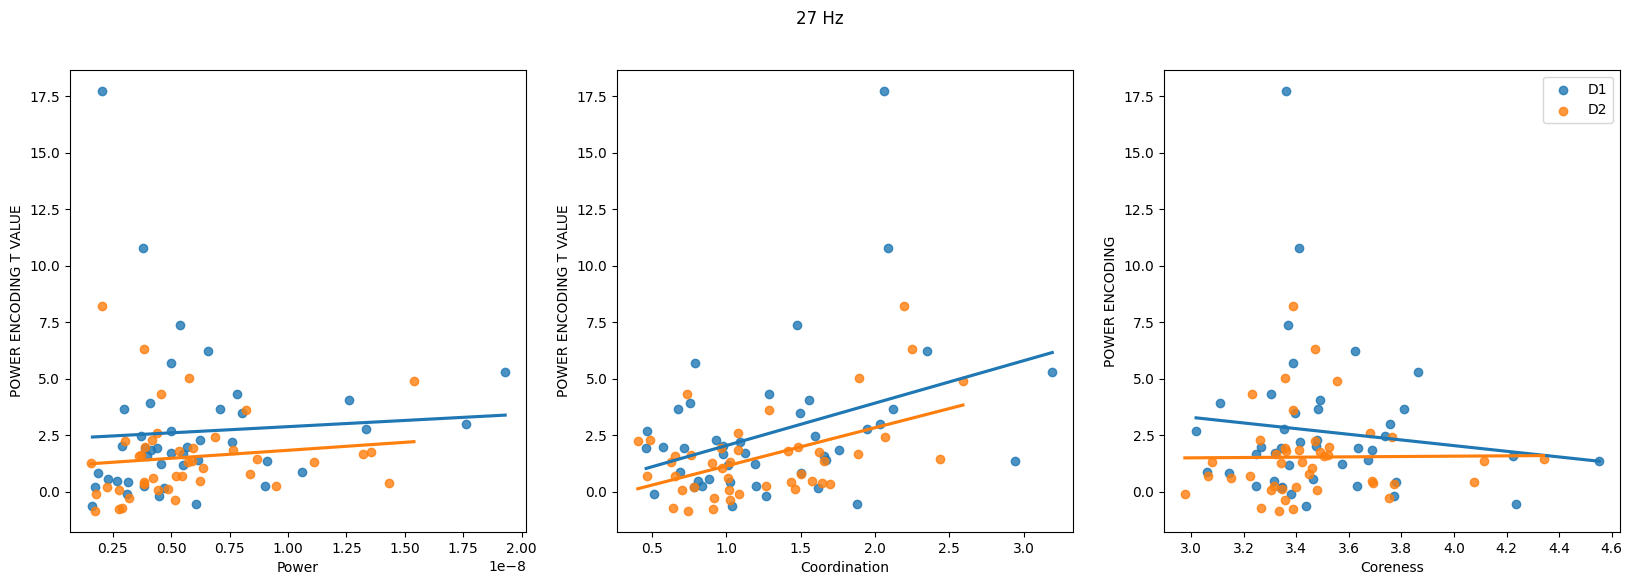

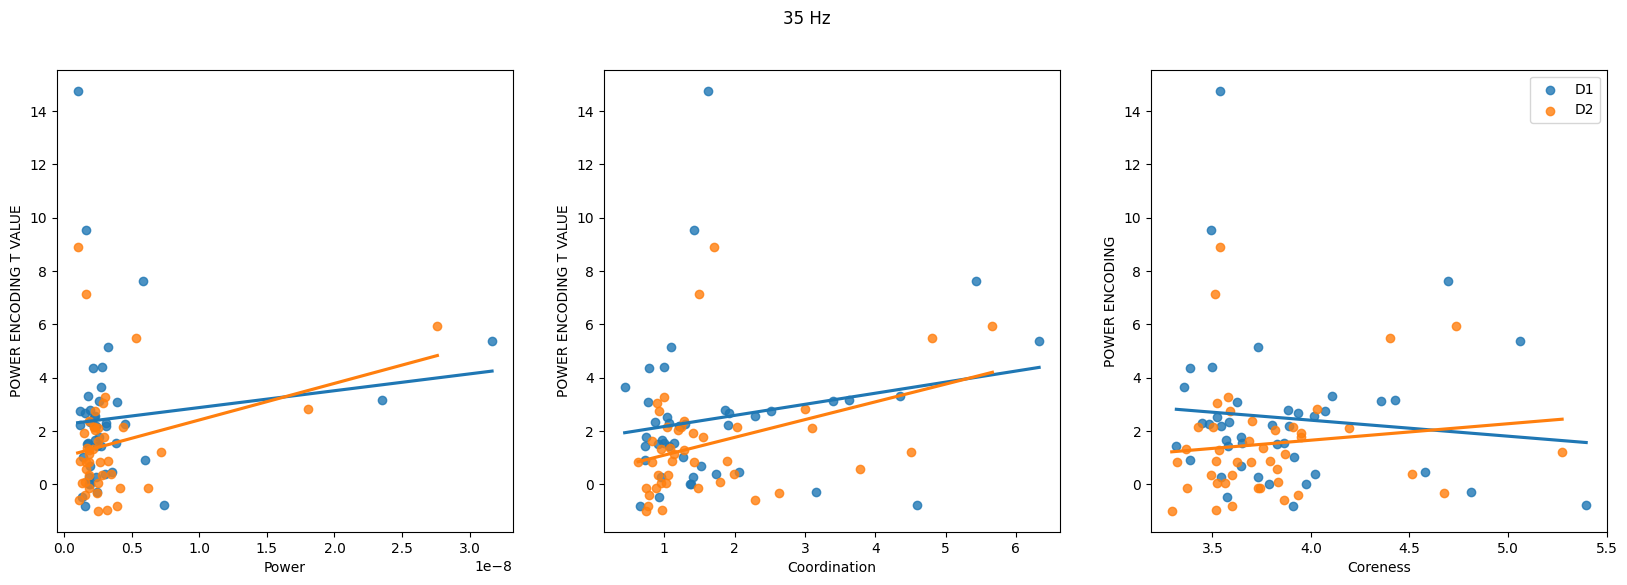

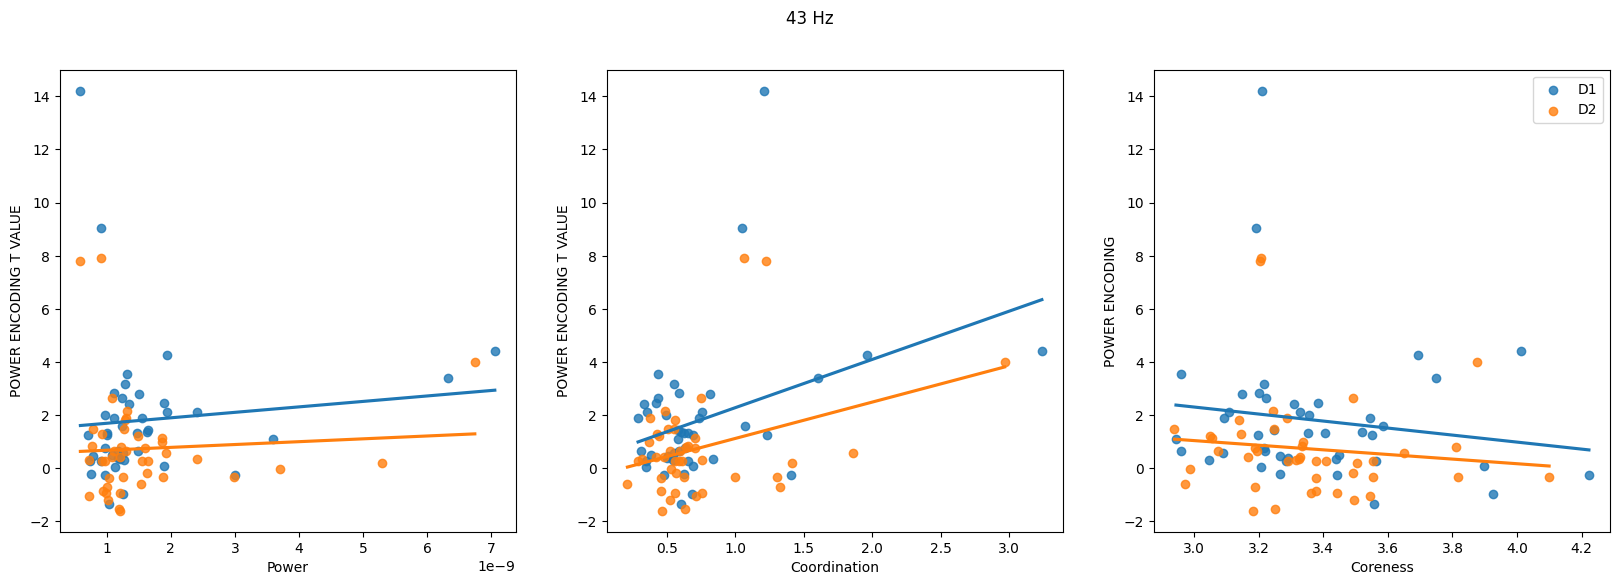

In [22]:
for f in [27, 35, 43]:

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    x = p.sel(freqs=f, times=2)
    y = t_pow.sel(freqs=f, times=2)
    sns.regplot(x=x, y=y, ci=None)

    x = p.sel(freqs=f, times=3)
    y = t_pow.sel(freqs=f, times=3)
    sns.regplot(x=x, y=y, ci=None)


    plt.xlabel("Power")
    plt.ylabel("POWER ENCODING T VALUE")

    plt.subplot(1, 3, 2)
    x = d.sel(freqs=f, times=2)
    y = t_pow.sel(freqs=f, times=2)
    sns.regplot(x=x, y=y, ci=None)

    x = d.sel(freqs=f, times=3)
    y = t_pow.sel(freqs=f, times=3)
    sns.regplot(x=x, y=y, ci=None)


    plt.xlabel("Coordination")
    plt.ylabel("POWER ENCODING T VALUE")

    plt.subplot(1, 3, 3)
    x = c.sel(freqs=f, times=2)
    y = t_pow.sel(freqs=f, times=2)
    sns.regplot(x=x, y=y, ci=None, label="D1")

    x = c.sel(freqs=f, times=3)
    y = t_pow.sel(freqs=f, times=3)
    sns.regplot(x=x, y=y, ci=None, label="D2")
    plt.legend()

    plt.xlabel("Coreness")
    plt.ylabel("POWER ENCODING")

    plt.suptitle(f"{f} Hz")

In [28]:
power = []
for session in tqdm(sessions):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    temp = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    temp_2 = []
    for ti, tf in stages:
        temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]

    temp_2 = xr.concat(temp_2, "times")

    power += [temp_2]
    
power = data_loader.apply_min_rois(power, 10)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.96it/s]


In [29]:
power = data_loader.apply_min_rois(power, 10)

In [30]:
power = power.sel(roi=t_pow.roi)

KeyError: "not all values found in index 'roi'"

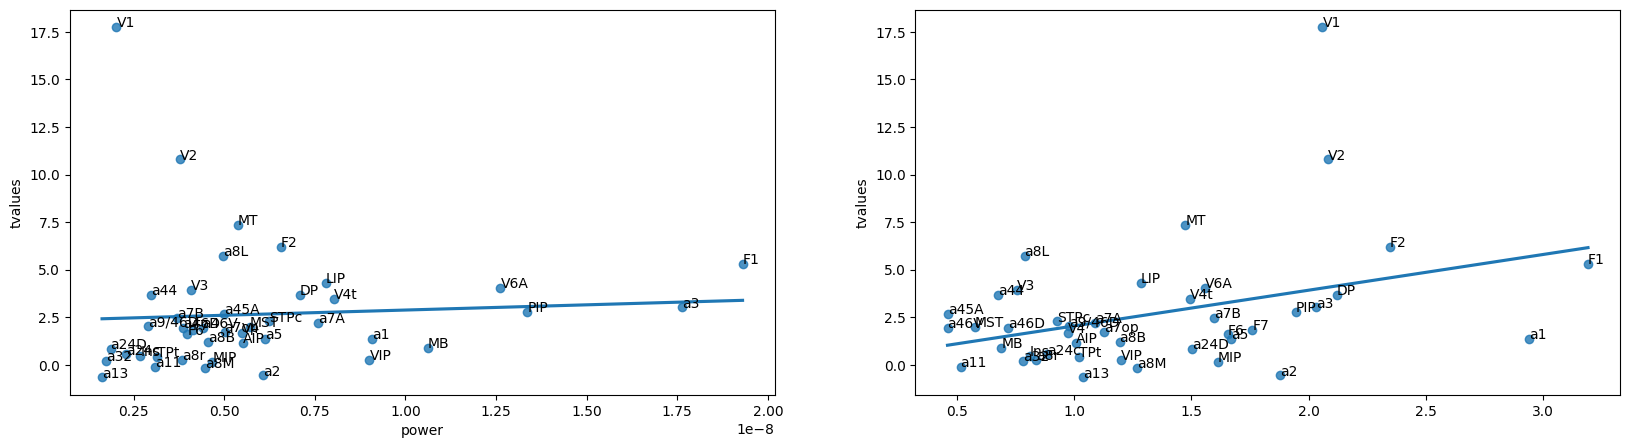

In [23]:
f = 27
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)

x = power.sel(freqs=f, times=2).sel(roi=t_pow.roi)
y = t_pow.sel(freqs=f, times=2)
sns.regplot(x=x, y=y, ci=None)
for i in range(len(x)):
    plt.text(x[i], y[i], x.roi.data[i])
    
plt.subplot(1, 2, 2)

x = d.sel(freqs=f, times=2).sel(roi=t_pow.roi)
y = t_pow.sel(freqs=f, times=2)
sns.regplot(x=x, y=y, ci=None)
for i in range(len(x)):
    plt.text(x[i], y[i], x.roi.data[i])

Text(0.5, 1.0, 'D1')

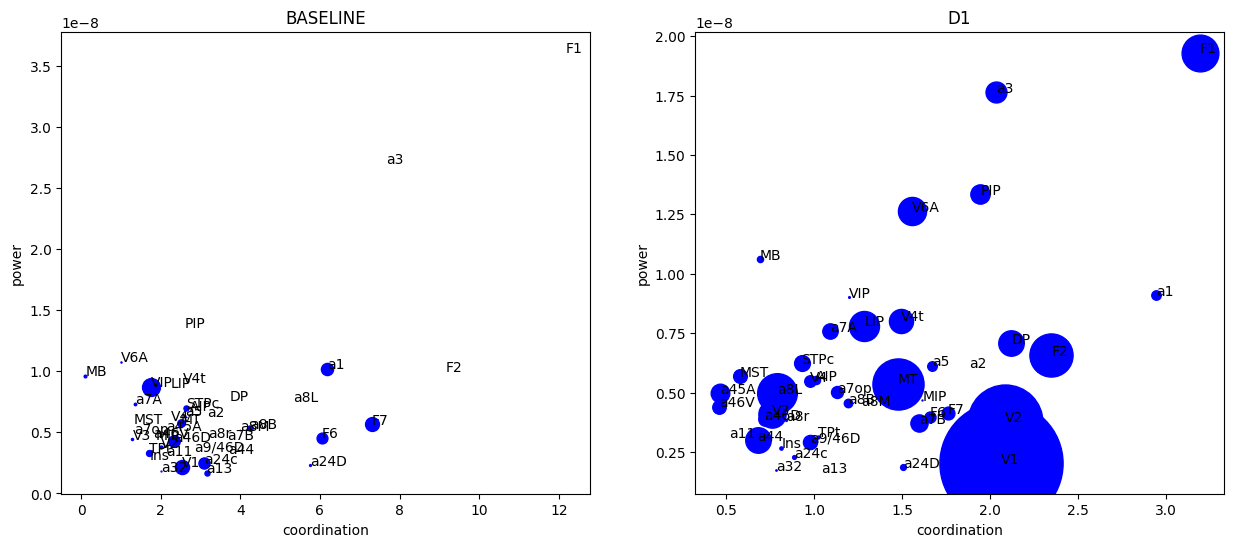

In [24]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
f = 27
t = 0
x = power.sel(freqs=f, times=t).sel(roi=t_pow.roi)
y = d.sel(freqs=f, times=t)
z = t_pow.sel(freqs=f, times=t)

for i in range(len(x)):
    plt.plot(y[i], x[i], "bo", ms=5 * z[i])
    plt.text(y[i], x[i], x.roi.data[i])
plt.ylabel("power")
plt.xlabel("coordination")
plt.title("BASELINE")
plt.subplot(1, 2, 2)

f = 27

t = 2
x = power.sel(freqs=f, times=t).sel(roi=t_pow.roi)
y = d.sel(freqs=f, times=t)
z = t_pow.sel(freqs=f, times=t)
for i in range(len(x)):
    plt.plot(y[i], x[i], "bo", ms=5 * z[i]) 
    plt.text(y[i], x[i], x.roi.data[i])
plt.ylabel("power")
plt.xlabel("coordination")
plt.title("D1")

In [ ]:
f = 27

t =3
x = power.sel(freqs=f, times=t).sel(roi=t_pow.roi)
y = d.sel(freqs=f, times=t)
z = t_pow.sel(freqs=f, times=t)
for i in range(len(x)):
    plt.plot(y[i], x[i], "bo", ms=5 * z[i]) 
    plt.text(y[i], x[i], x.roi.data[i])
plt.ylabel("power")
plt.xlabel("coordination")

In [33]:
plt.figure(figsize=(20, 20))
ccs = np.zeros((10, 5, 200))
pos = 1
for f in tqdm(range(10)):
    for t in range(5):

        ccs[f, t] = draw_bs_pairs_reps_pearson(
            power.isel(freqs=f, times=t), t_pow.isel(freqs=f, times=t), 200
        )

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


<Figure size 1440x1440 with 0 Axes>

In [34]:
ccs = confidence_interval(
    xr.DataArray(ccs, dims=("freqs", "times", "boot")), axis=2
).squeeze()

    Estimating CI (cis=[95], axis=2, n_boots=200, skipna=True, random_state=None)


[None, None]

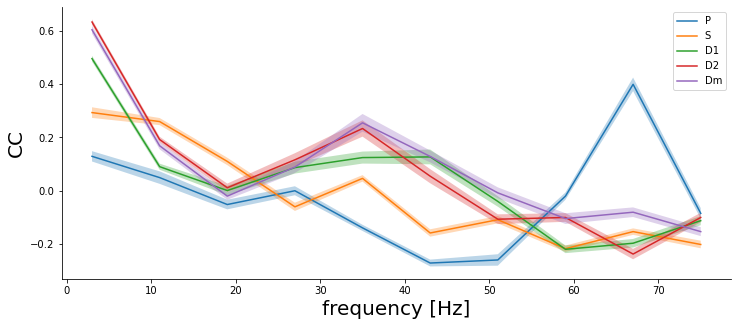

In [35]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(111)
for t in range(5):
    plt.plot(t_pow.freqs, ccs.sel(times=t).mean("bound"), label=stage_labels[t])
    plt.fill_between(
        t_pow.freqs,
        ccs.sel(bound="low", times=t),
        ccs.sel(bound="high", times=t),
        alpha=0.3,
    )

plt.legend()
plt.xlabel("frequency [Hz]", fontsize=20)
plt.ylabel("CC", fontsize=20)
plt.title("")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

In [31]:
p_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "pval_pow_1_br_1_aligned_cue_avg_0_cluster_slvr_0.nc")
    )
)
t_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "tval_pow_1_br_1_aligned_cue_avg_0_cluster_slvr_0.nc")
    )
)

In [32]:
t_pow = t_pow * (p_pow <= 0.01)

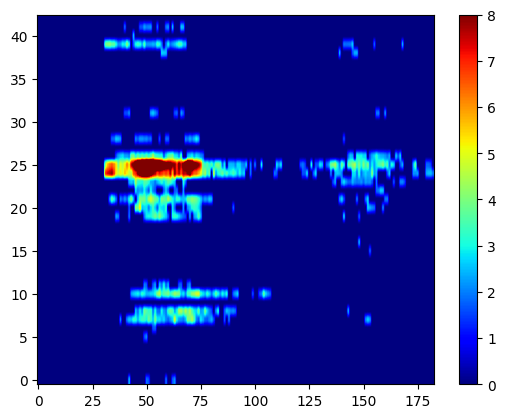

In [45]:
plt.imshow(t_pow.sel(freqs=27).T, aspect="auto", origin="lower", vmax=8, cmap="jet")
plt.colorbar()